In [23]:
library(pacman)
p_load(dplyr,tidyr,splines,glarma)

In [24]:
setwd('C:\\Users\\Marcelo\\OneDrive\\Área de Trabalho\\ts\\trabalho 2 - TS\\Trabalho7')
getwd()

[1] "C:/Users/Marcelo/OneDrive/Área de Trabalho/ts/trabalho 2 - TS/Trabalho7"

Função de Verossimilhança da Professora:

In [25]:
Like <- function(Parametros, y, nb, np, nq, lamb, x, Ind) {
  
    
  ny <- length(y)
  
  # Separating parameters: beta, fi, theta
  if (nb > 0) {
    beta <- Parametros[1:nb]
  }
  
  ar_ma_start <- nb + 1
  
  if (np > 0 && nq == 0) {
    fi <- Parametros[ar_ma_start:(ar_ma_start + np - 1)]
  }
  
  if (nq > 0 && np == 0) {
    theta <- Parametros[ar_ma_start:(ar_ma_start + nq - 1)]
  }
  
  if (np > 0 && nq > 0) {
    fi <- Parametros[ar_ma_start:(ar_ma_start + np - 1)]
    theta <- Parametros[(ar_ma_start + np):(ar_ma_start + np + nq - 1)]
  }
  
  # Initialize variables
  z    <- rep(0, ny)
  w    <- rep(0, ny)
  mi   <- rep(0, ny)
  erro <- rep(0, ny)
  
  # First observation: compute w[1]
  if (nb == 0) {
    w[1] <- 0
  } else if (nb == 1) {
    w[1] <- beta[1]
  } else {
    w[1] <- beta[1] + as.numeric(x[1, 1:(nb - 1)] %*% beta[2:nb])
  }
  
  mi[1]   <- exp(w[1])
  erro[1] <- (y[1] - mi[1]) / (mi[1]^lamb)
  L       <- y[1] * w[1] - exp(w[1])
  
  # Loop over t = 2 to ny
  for (t in 2:ny) {
    
    # AR component
    if (np > 0) {
      for (k in 1:min(np, t - 1)) {
        z[t] <- z[t] + fi[k] * (z[t - k] + erro[t - k])
      }
    }
    
    # MA component
    if (nq > 0) {
      for (k in 1:min(nq, t - 1)) {
        z[t] <- z[t] + theta[k] * erro[t - k]
      }
    }
    
    # Compute w[t] based on z[t] and x[t,]
    if (nb == 0) {
      w[t] <- z[t]
    } else if (nb == 1) {
      w[t] <- beta[1] + z[t]
    } else {
      w[t] <- beta[1] + as.numeric(x[t, 1:(nb - 1)] %*% beta[2:nb]) + z[t]
    }
    
    mi[t]   <- exp(w[t])
    erro[t] <- (y[t] - mi[t]) / (mi[t]^lamb)
    L       <- L + y[t] * w[t] - exp(w[t])
  }
  
  L <- -L  # negative log-likelihood
  
  valores <- cbind(erro, z, mi)
  
  if (Ind == 0) return(L)
  if (Ind == 1) return(valores)
}


Função que adiciona faz a estimação, calcula o AIC dado o numero de bases para cada covariável não linear:

In [26]:
MLE_com_splines <- function(y, z_list, k_list,
                          other_covariates = NULL,
                          np = 0, nq = 0, lamb = 0.5,
                          Ind = 0) {
  
  nz <- length(z_list)
  
  # Construindo as bases splines com seus respectivos ks.
  spline_list <- list()
  spline_sizes <- integer(nz)
  
  for (i in seq_along(z_list)) {
    k_i <- k_list[[i]]
    spline_i <- ns(z_list[[i]], df = k_i) #bases splines para a variável não linear numero i
    spline_list[[i]] <- spline_i #lista com as bases
    spline_sizes[i] <- ncol(spline_i) #numero de bases a variavel não linear i
  }

  # juntando as bases splines usando cbind:
  names(spline_list) <- names(z_list)
  spline_basis <- do.call(cbind, spline_list)
  n_spline <- sum(spline_sizes)
  
  # Juntando com as outras covariáveis:
  if (!is.null(other_covariates)) {
    x <- cbind(spline_basis, other_covariates)
    n_other <- ncol(other_covariates)
  } else {
    x <- spline_basis
    n_other <- 0
  }
  
  nb <- 1 + n_spline + n_other  # intercepto + splines + numero betas das outras cov
  n_params <- nb + np + nq
  start_vals <- rep(0, n_params)

  # ajustando o modelo dado um numero fixo de bases para cada covariável não linear:
  opt <- optim(par = start_vals,
               fn = Like,
               y = y,
               nb = nb,
               np = np,
               nq = nq,
               lamb = lamb,
               x = x,
               Ind = Ind,
               method = "BFGS",
               hessian = FALSE)

  logLik <- -opt$value
  AIC <- 2 * n_params - 2 * logLik

  best_coef <- opt$par
  beta0 <- best_coef[1]
  beta_spline_all <- best_coef[2:(1 + n_spline)]
  
  # separando os coeficientes das bases splines para cada variável não linear:
  beta_spline_list <- list()
  idx <- 1
  for (i in seq_along(z_list)) {
    varname <- names(z_list)[i]
    len <- spline_sizes[i]
    beta_spline_list[[varname]] <- beta_spline_all[idx:(idx + len - 1)]
    idx <- idx + len
  }
    
  # separando os outros coeficientes:
  beta_other <- if (n_other > 0)
      {best_coef[(2 + n_spline):(1 + n_spline + n_other)]}
                else {numeric(0)}
    
  fi   <- if (np > 0) 
      {best_coef[(nb + 1):(nb + np)]}
                else {numeric(0)}
  
  theta <- if (nq > 0) 
      {best_coef[(nb + np + 1):(nb + np + nq)]} 
       else {numeric(0)}

  fit <- list(
    AIC = AIC,
    logLik = logLik,
    beta0 = beta0,
    beta_spline = beta_spline_list,
    beta_other = beta_other,
    fi = fi,
    theta = theta,
    k_list = k_list
  )

  return(fit)
}


In [27]:
select_best_k_multi <- function(y, z_list, k_ranges,
                                other_covariates = NULL,
                                np = 0, nq = 0, lamb = 0.5,
                                Ind = 0) {
  
  # Gerando um grid com os possíveis numeros de bases para cada variável spline:
    
  k_grid <- expand.grid(k_ranges)
  
  best_AIC <- Inf
  best_fit <- NULL
  best_k_list <- NULL
  
 #calculando o AIC para cada combinação de número de bases:
  for (i in seq_len(nrow(k_grid))) 
  {
    current_k <- as.list(k_grid[i, ])
    
    result <- tryCatch({
                          MLE_com_splines(
                            y = y,
                            z_list = z_list,
                            k_list = current_k,
                            other_covariates = other_covariates,
                            np = np,
                            nq = nq,
                            lamb = lamb,
                            Ind = Ind
                          )
                        }, 
                       error = function(e) {return(NULL)}
                      )
    
    if (!is.null(result) && result$AIC < best_AIC) {
        
      best_AIC <- result$AIC
      best_fit <- result
      best_k_list <- current_k
    }
  }
    
  best_fit$k_list <- best_k_list
  return(best_fit)
}


Pegando o dataset de Doença respiratórias:

In [28]:
df <- read.csv("DR.csv",header = TRUE,sep=';')

In [29]:
summary(df)

     Data            Atendimentos    tempmed               O3           
 Length:72          Min.   : 1.0   Length:72          Length:72         
 Class :character   1st Qu.:12.0   Class :character   Class :character  
 Mode  :character   Median :21.5   Mode  :character   Mode  :character  
                    Mean   :24.1                                        
                    3rd Qu.:33.0                                        
                    Max.   :91.0                                        
      CO                NO2                SO2           
 Length:72          Length:72          Length:72         
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         

In [30]:
df<- df %>% select(Atendimentos,tempmed,O3,CO,NO2,SO2)

Limpando os dados:

In [31]:
df[] <- lapply(df, function(x) {
  if (is.character(x)) as.numeric(gsub(",", ".", x)) else x
})

In [32]:
summary(df)

  Atendimentos     tempmed            O3              CO        
 Min.   : 1.0   Min.   :18.85   Min.   :16.76   Min.   : 295.2  
 1st Qu.:12.0   1st Qu.:22.61   1st Qu.:26.34   1st Qu.: 645.7  
 Median :21.5   Median :23.97   Median :32.22   Median : 829.8  
 Mean   :24.1   Mean   :24.17   Mean   :32.72   Mean   : 826.8  
 3rd Qu.:33.0   3rd Qu.:26.02   3rd Qu.:38.44   3rd Qu.:1018.4  
 Max.   :91.0   Max.   :29.14   Max.   :48.15   Max.   :1616.3  
      NO2             SO2        
 Min.   :11.19   Min.   : 5.959  
 1st Qu.:19.33   1st Qu.: 9.361  
 Median :24.45   Median :11.140  
 Mean   :24.42   Mean   :11.809  
 3rd Qu.:28.70   3rd Qu.:13.695  
 Max.   :38.72   Max.   :20.420  

In [33]:
df<- df %>% drop_na()

Montando o X:

In [34]:
X <- as.matrix(df[ , setdiff(names(df), "Atendimentos")])

Ajustando o modelo sem os splines:

In [35]:
fit =glarma(df$Atendimentos, X=X , phiLags = c(1) ,thetaLags = NULL, type = "Poi")
summary(fit)


Call: glarma(y = df$Atendimentos, X = X, type = "Poi", phiLags = c(1), 
    thetaLags = NULL)

Pearson Residuals:
    Min       1Q   Median       3Q      Max  
-5.1470  -1.5949  -0.2822   1.8875  11.4303  

GLARMA Coefficients:
      Estimate Std.Error z-ratio Pr(>|z|)    
phi_1 0.064316  0.007945   8.095 6.66e-16 ***

Linear Model Coefficients:
          Estimate  Std.Error z-ratio Pr(>|z|)    
tempmed  0.0626788  0.0080746   7.763 8.44e-15 ***
O3       0.0417608  0.0038306  10.902  < 2e-16 ***
CO       0.0018250  0.0001737  10.508  < 2e-16 ***
NO2     -0.0078196  0.0055289  -1.414    0.157    
SO2     -0.0994414  0.0113291  -8.778  < 2e-16 ***

    Null deviance: 795.53  on 71  degrees of freedom
Residual deviance: 612.48  on 66  degrees of freedom
AIC: 943.4291 

Number of Fisher Scoring iterations: 30

LRT and Wald Test:
Alternative hypothesis: model is a GLARMA process
Null hypothesis: model is a GLM with the same regression structure
          Statistic  p-value    
LR Test     

In [36]:
fit =glarma(df$Atendimentos, X=X[,c('tempmed','O3','CO','SO2')] , phiLags = c(1,2) ,thetaLags = NULL, type = "Poi")
summary(fit)


Call: glarma(y = df$Atendimentos, X = X[, c("tempmed", "O3", "CO", 
    "SO2")], type = "Poi", phiLags = c(1, 2), thetaLags = NULL)

Pearson Residuals:
    Min       1Q   Median       3Q      Max  
-5.2529  -1.7941  -0.1555   1.4626   8.5222  

GLARMA Coefficients:
      Estimate Std.Error z-ratio Pr(>|z|)    
phi_1 0.082932  0.008198  10.116  < 2e-16 ***
phi_2 0.046149  0.008895   5.188 2.13e-07 ***

Linear Model Coefficients:
          Estimate  Std.Error z-ratio Pr(>|z|)    
tempmed  0.0639349  0.0083392   7.667 1.75e-14 ***
O3       0.0364563  0.0032981  11.054  < 2e-16 ***
CO       0.0013487  0.0001142  11.814  < 2e-16 ***
SO2     -0.0720963  0.0118371  -6.091 1.12e-09 ***

    Null deviance: 795.53  on 71  degrees of freedom
Residual deviance: 578.17  on 66  degrees of freedom
AIC: 917.5981 

Number of Fisher Scoring iterations: 30

LRT and Wald Test:
Alternative hypothesis: model is a GLARMA process
Null hypothesis: model is a GLM with the same regression structure
          St

A partir do AR(2) os coeficientes do phi não são significativos em todos os níveis de confiança.

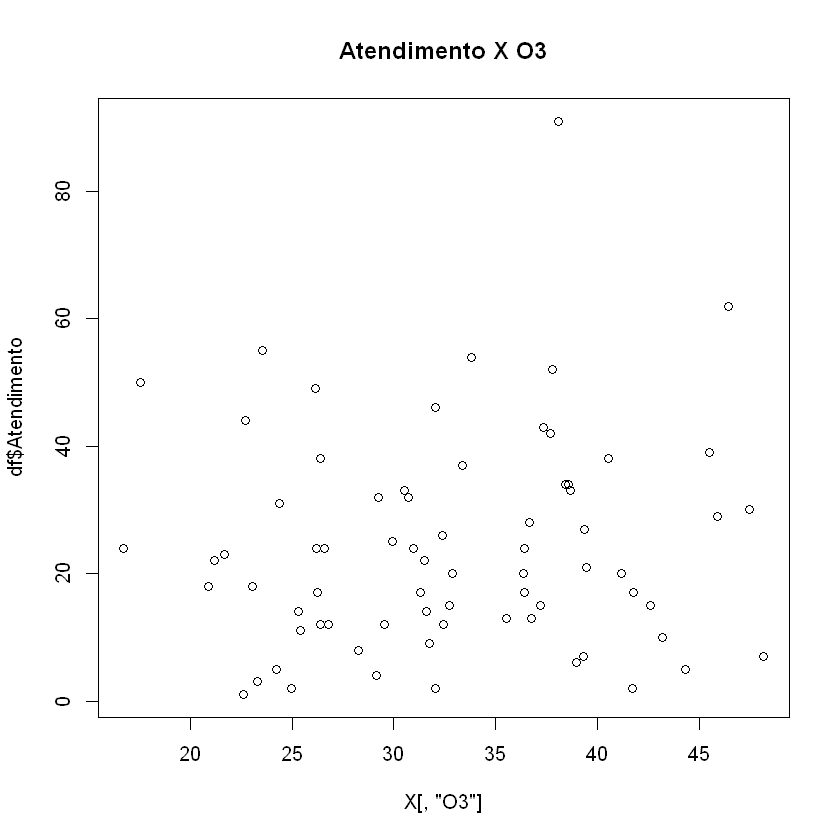

In [37]:
plot(X[, "O3"], df$Atendimento, main = "Atendimento X O3")

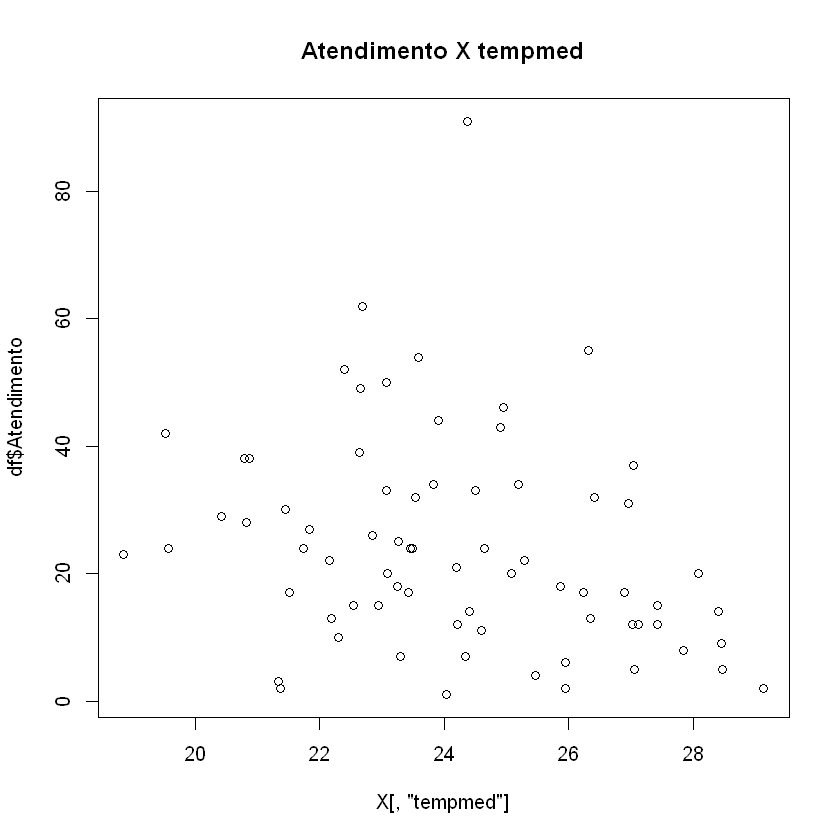

In [38]:
plot(X[, "tempmed"], df$Atendimento, main = "Atendimento X tempmed")

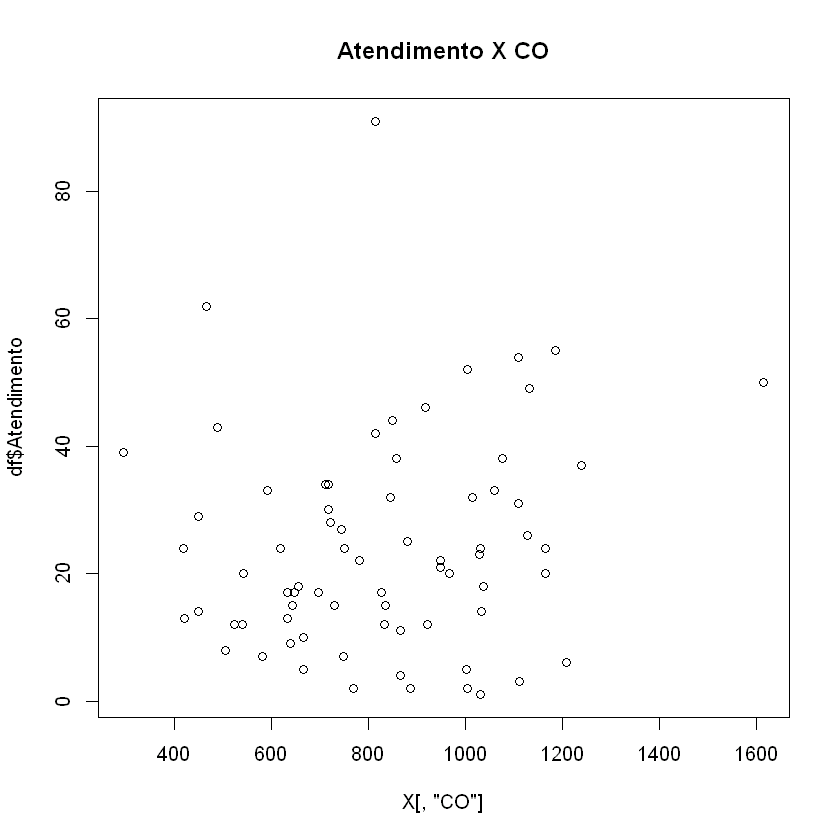

In [39]:
plot(X[, "CO"], df$Atendimento, main = "Atendimento X CO")

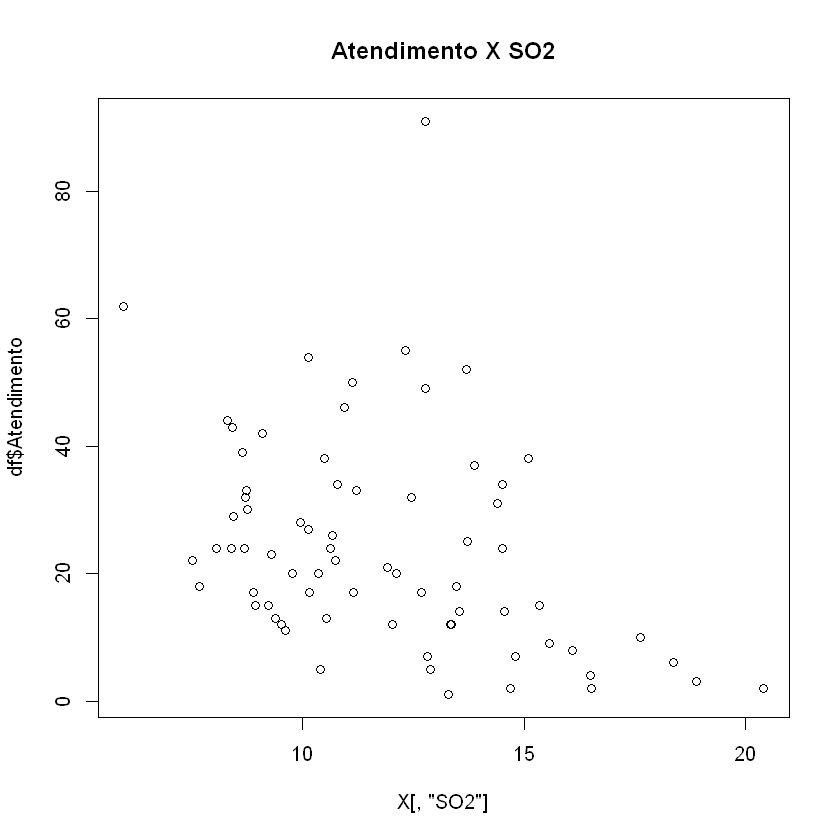

In [40]:
plot(X[, "SO2"], df$Atendimento, main = "Atendimento X SO2")

O3 aparentemente tem relação não linear com o número de atendimentos

Rodando nossa regressão com os splines:

In [41]:
other_covs <- X[,c('tempmed','CO','SO2')]

In [42]:
resposta<-select_best_k_multi(y=df$Atendimentos,z=list(O3=df$O3,tempmed=df$tempmed),other_covariates = other_covs,
                        k_ranges=list(O3=1:8,temp_med=1:8),np=3,nq=0,lamb =0.5,Ind=0)

In [43]:
resposta

$AIC
[1] -7840.307

$logLik
[1] 3942.154

$beta0
[1] 2.763066

$beta_spline
$beta_spline$O3
[1]  0.35172761  0.74833977  0.05146254  1.07794205 -0.52101027  0.57268612
[7]  0.63610100

$beta_spline$tempmed
[1] -0.10411575 -0.34278466 -0.02068668 -0.12711309 -0.62225236  0.05638341
[7] -1.64067137 -1.73036851


$beta_other
[1]  0.0284734534  0.0007403021 -0.0866522606

$fi
[1]  0.043346720  0.002271013 -0.066077235

$theta
numeric(0)

$k_list
$k_list$O3
[1] 7

$k_list$temp_med
[1] 8

attr(,"out.attrs")
attr(,"out.attrs")$dim
      O3 temp_med 
       8        8 

attr(,"out.attrs")$dimnames
attr(,"out.attrs")$dimnames$O3
[1] "O3=1" "O3=2" "O3=3" "O3=4" "O3=5" "O3=6" "O3=7" "O3=8"

attr(,"out.attrs")$dimnames$temp_med
[1] "temp_med=1" "temp_med=2" "temp_med=3" "temp_med=4" "temp_med=5"
[6] "temp_med=6" "temp_med=7" "temp_med=8"